In [3]:
from pathlib import Path
import pickle

import arviz as az
from einops import rearrange
import jax.numpy as jnp
from jax.tree_util import tree_map
from matplotlib import pyplot as plt
from mubelnet.utils import cluster_latent_components
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.metrics import silhouette_samples
from scripts.dataset import load_mutation_spectrum, COSMIC_WEIGHTS
from scripts.plot import spectrum_plot_with_95ci, plot_cosmic_2nd_order_signatures_95ci

RANDOM_SEED = 43
CONTEXT = 96
MODEL = "multinomial_dirichlet_believe"
n_topics = len(COSMIC_WEIGHTS)
X_train, X_test, _ = load_mutation_spectrum(random_state=RANDOM_SEED, context=CONTEXT)

In [4]:
trace_dir = Path(f'../{MODEL}/41-86/samples/')
pickles = sorted(trace_dir.glob('sample_*.pkl'))
state_checkpoints = []
for p_file in pickles[-3:]:
    with open(p_file, 'rb') as fi:
        trace_mdbn = pickle.load(fi)
        states_thinned = tree_map(lambda x: x[:, ::1], trace_mdbn)
        del trace_mdbn
        state_checkpoints.append(states_thinned)

trace_mdbn = tree_map(lambda *xs: jnp.concatenate(xs, axis=1), *state_checkpoints)
state_avg = tree_map(lambda x: jnp.mean(x, axis=1), trace_mdbn)

In [5]:
def at_i(i, state):
    return tree_map(lambda x: x[i], state)

idata = az.convert_to_inference_data(
    {
        "c(3)": trace_mdbn[f"{MODEL}/~/cap_layer"]["c"],
        "c(2)": trace_mdbn[f"{MODEL}/~/dirichlet_layer"]["c"],
    }
)
c_summary = az.summary(idata)
print(c_summary)

        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
c(3)   0.289  0.034   0.225    0.334      0.016    0.013       5.0      12.0   
c(2)  34.456  4.664  26.841   39.319      2.282    1.742       5.0      11.0   

      r_hat  
c(3)   2.70  
c(2)   3.43  


In [6]:
m_k = state_avg[f'{MODEL}/~/cap_layer']['m_k']
r_k = state_avg[f'{MODEL}/~/cap_layer']['r']
r_trace = trace_mdbn[f'{MODEL}/~/cap_layer']['r'].copy()
phi_2_trace = trace_mdbn[f'{MODEL}/~/dirichlet_layer']['phi'].copy()
phi_2 = state_avg[f'{MODEL}/~/dirichlet_layer']['phi']
phi_1 = COSMIC_WEIGHTS.to_numpy()
del trace_mdbn

In [7]:
cluster_assignments, centroids = cluster_latent_components(
    phi_2, n_iterations=10, metric_name="jensenshannon"
)

# Invert cluster assignment mappings.
cluster_assignments_inv = np.zeros_like(cluster_assignments)
n_chains, n_topics = cluster_assignments.shape
for k in range(n_topics):
    for j in range(n_chains):
        cluster_assignments_inv[j, int(cluster_assignments[j, k])] = k

In [8]:
# Compute the centroid for each element in trace.
centroid_trace = np.zeros(phi_2_trace.shape[1:])
for k in range(n_topics):
    for j in range(n_chains):
        idx_c_k = cluster_assignments_inv[j, k]
        centroid_trace[:, k] += phi_2_trace[j, :, idx_c_k]
    centroid_trace[:, k] /= n_chains

In [9]:
x_flat = phi_2.reshape([n_chains * n_topics, -1])
distances = pdist(x_flat, metric='jensenshannon')
X_dist = squareform(distances)

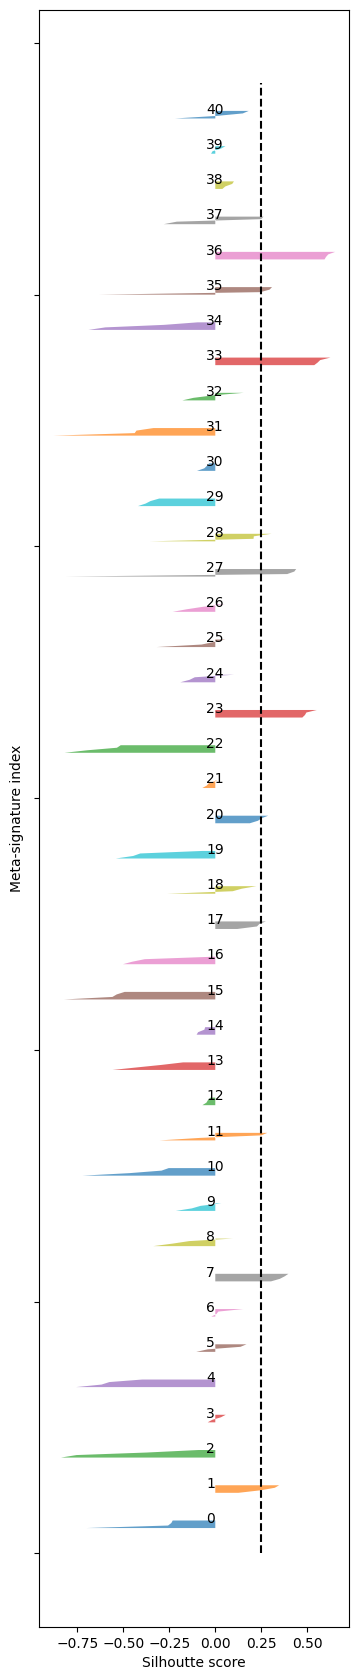

In [10]:
silhouettes = silhouette_samples(X_dist, cluster_assignments.flatten(), metric="precomputed")

# Make a silhouette plot for the assigned clusters.
fig, ax = plt.subplots(figsize=(4, 21))
y_lower = 10
for i in range(n_topics):
    ith_cluster_silhouette_values = silhouettes[cluster_assignments.flatten() == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    ax.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

silhouette_threshold = 0.25
ax.set_yticklabels([])
plt.plot([silhouette_threshold, silhouette_threshold], [0, y_lower], "k--")
plt.ylabel('Meta-signature index')
plt.xlabel('Silhoutte score')
plt.savefig(f'../figures/silhouette.png', bbox_inches='tight', dpi=300)

In [11]:
# Select topics where all chains exceed the silhouette threshold.
reproducable_clusters = []
for i in range(n_topics):
    ith_cluster_silhouette_values = silhouettes[cluster_assignments.flatten() == i]
    if np.all(ith_cluster_silhouette_values > silhouette_threshold):
        reproducable_clusters.append(i)

In [12]:
for i in range(4):
    topic_i = cluster_assignments_inv[i, reproducable_clusters]
    # Verify that all chains have at least 20 topics assigned to it.
    # assert np.all(m_k[i, topic_i] > 20)
    print(f'm_k (chain: {i})', m_k[i, topic_i])

m_k (chain: 0) [80511.66      453.30002 16964.34     1949.4268 ]
m_k (chain: 1) [98787.445   1471.6667 33635.633   1428.02  ]
m_k (chain: 2) [24908.58    1317.5333 11903.467   1417.7267]
m_k (chain: 3) [49056.61     708.38   39351.035   2489.7935]


In [13]:
meta_signatures = []
for i in range(4):
    topic_i = cluster_assignments_inv[i, reproducable_clusters]
    meta_signatures.append(phi_2_trace[i, :, topic_i])
meta_signatures = jnp.stack(meta_signatures, axis=0)

meta_signatures = rearrange(meta_signatures, 'c k n j -> c n k j')

In [14]:
phi_2_entropy = entropy(meta_signatures, axis=-1)
idata = az.convert_to_inference_data(
    {
        "M_1": phi_2_entropy[:, :, 0],
        "M_2": phi_2_entropy[:, :, 1],
        "M_3": phi_2_entropy[:, :, 2],
        "M_4": phi_2_entropy[:, :, 3],
    }
)

az.summary(idata, var_names=["M_1", "M_2", "M_3", "M_4"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M_1,2.97,0.07,2.90,3.11,0.04,0.03,5.41,12.87,2.13
M_2,2.58,0.34,1.99,3.06,0.16,0.12,4.91,27.58,2.61
M_3,2.95,0.06,2.85,3.06,0.03,0.02,5.05,25.61,2.47
M_4,3.04,0.06,2.95,3.15,0.02,0.01,9.50,135.20,1.37


In [15]:
phi_projection = centroids @ phi_1
phi_phi_trace = centroid_trace @ phi_1

In [16]:
COSMIC_WEIGHTS.index

n_components = centroids.shape[0]
n_signatures = COSMIC_WEIGHTS.shape[0]
tau_t=3
uniform_threshold = tau_t / n_signatures
is_in_sign = centroids > uniform_threshold

for j in reproducable_clusters:
    print(f'Component {j+1}')
    signatures = COSMIC_WEIGHTS.index[is_in_sign[j]]
    print(signatures)

Component 8
Index(['SBS1', 'SBS2', 'SBS3', 'SBS5', 'SBS8', 'SBS13', 'SBS37', 'SBS39',
       'SBS40'],
      dtype='object')
Component 24
Index(['SBS10a', 'SBS10b', 'SBS15', 'SBS21', 'SBS28'], dtype='object')
Component 34
Index(['SBS1', 'SBS8', 'SBS17a', 'SBS17b', 'SBS18'], dtype='object')
Component 37
Index(['SBS7b', 'SBS12', 'SBS23', 'SBS37', 'SBS39', 'SBS87', 'SBS88', 'SBS94'], dtype='object')


In [17]:
reproducable_names = {'M$_1$': 27, 'M$_2$': 20, 'M$_3$': 15, 'M$_4$': 10}
n_meta_signatures = 41
# Also name the remaining signatures which had a silhouette score < 0.25.
remaining_names = {}
i = 4
for idx in range(n_meta_signatures):
    if idx not in reproducable_names.values():
        remaining_names[f'M$_{{{i+1}}}$'] = idx
        i += 1

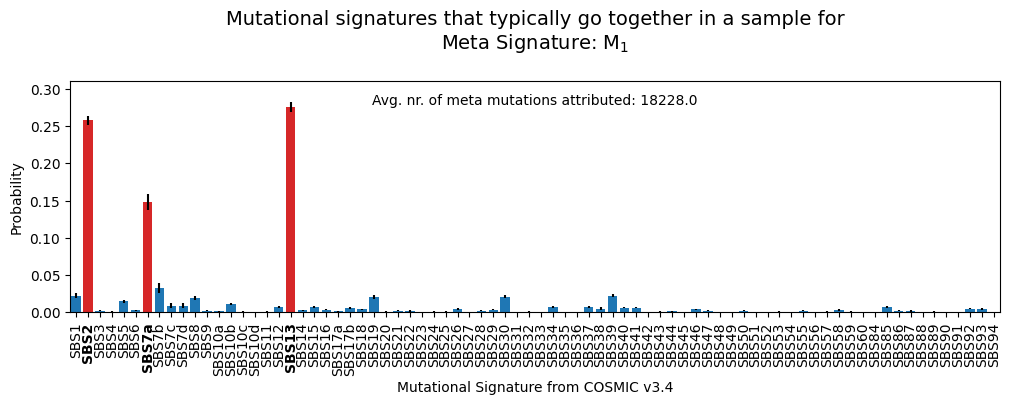

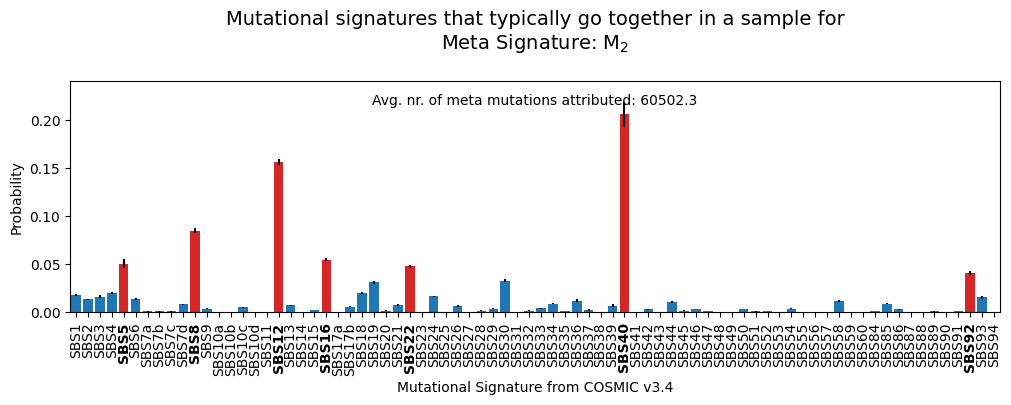

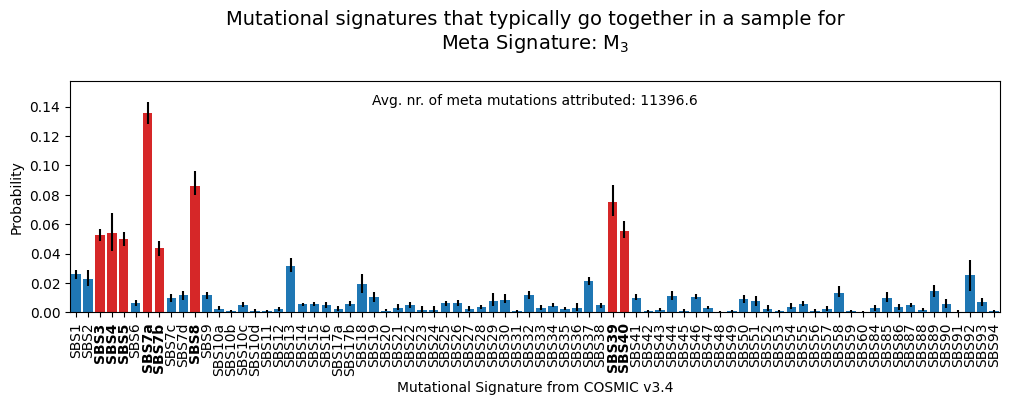

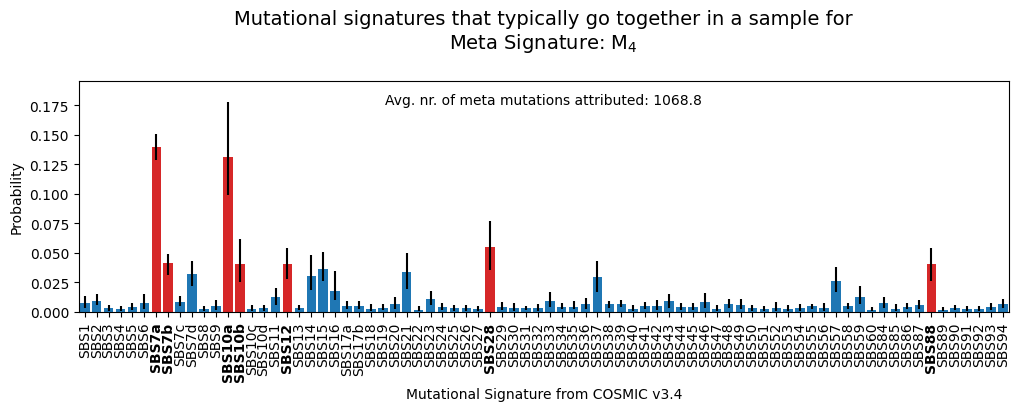

In [22]:
for name, idx in reproducable_names.items():
   f = plt.figure(figsize=(12, 3))
   plt.title(f"Mutational signatures that typically go together in a sample for\nMeta Signature: {name}\n", fontsize=14)
   plot_cosmic_2nd_order_signatures_95ci(centroid_trace[:, idx])
   output_name = name.replace('$', '').replace('_', '').replace('{', '').replace('}', '')
   f.savefig(f'../figures/{output_name}_meta.png', bbox_inches='tight', dpi=300)
   # Compute the number of meta mutations that were attributed to these meta-signatures.
   avg_meta_counts = m_k[np.arange(4), cluster_assignments_inv[:, idx]].mean()
   plt.text(0.5, 0.9, f'Avg. nr. of meta mutations attributed: {avg_meta_counts:.1f}', transform=plt.gca().transAxes, ha="center",)
   f.savefig(f'../figures/meta_signatures/{output_name}_meta.png', bbox_inches='tight', dpi=300)

d:\dev\stage\DeepBayesMutSig\analyses\notebooks\scripts\plot.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(map(trinucleotide, x_sorted_trinuc)), size=8)


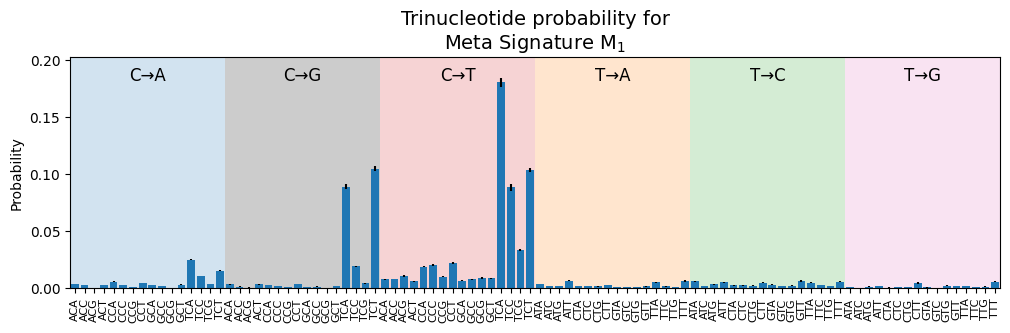

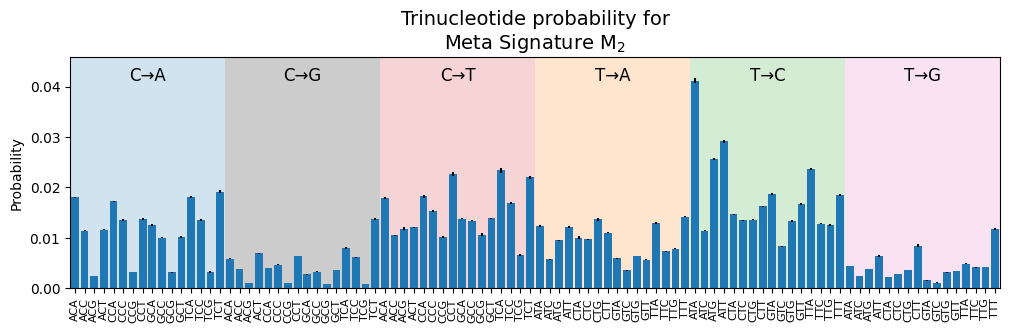

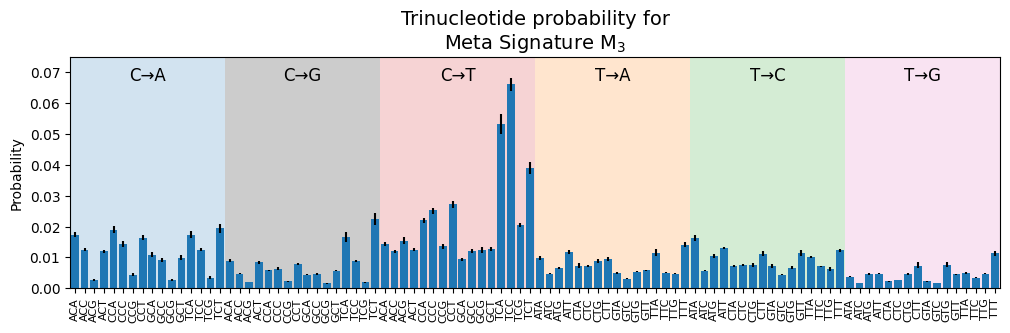

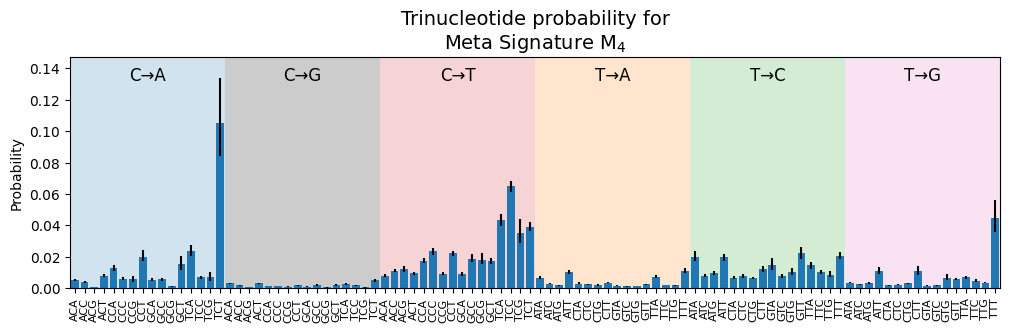

In [21]:
for name, idx in reproducable_names.items():
    f = plt.figure(figsize=(12, 3))
    plt.title(f"Trinucleotide probability for\nMeta Signature {name}", fontsize=14)
    spectrum_plot_with_95ci(phi_phi_trace[:, idx])
    output_name = name.replace('$', '').replace('_', '').replace('{', '').replace('}', '')
    f.savefig(f'../figures/{output_name}_spectrum.png', bbox_inches='tight', dpi=300)

C:\Users\John\AppData\Local\Temp\ipykernel_9552\1747205392.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(12, 3))


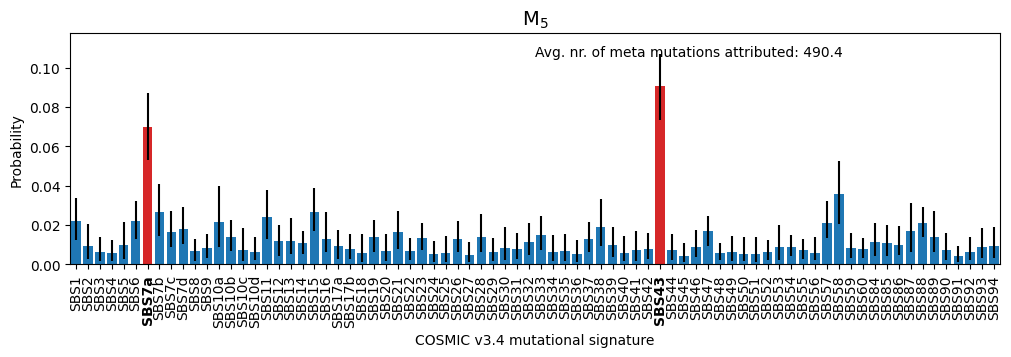

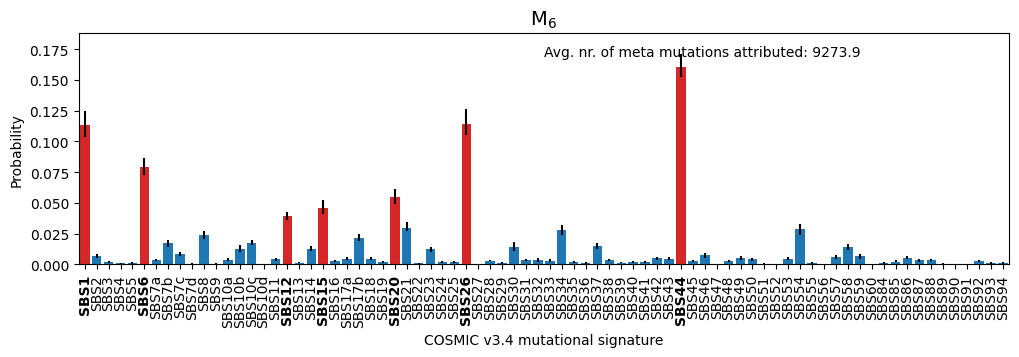

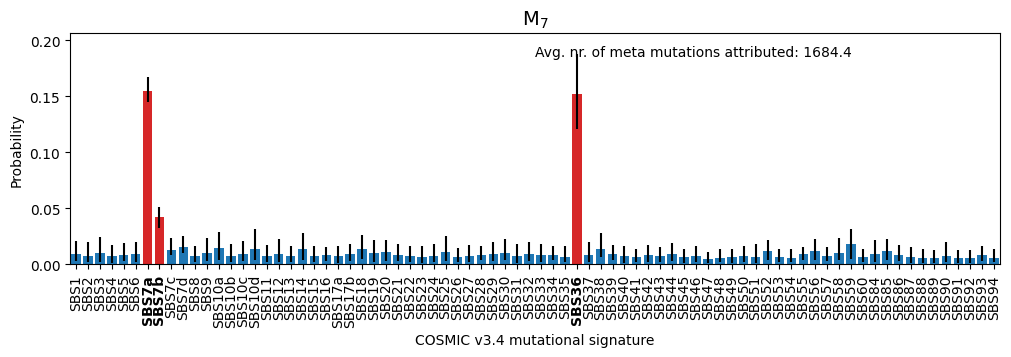

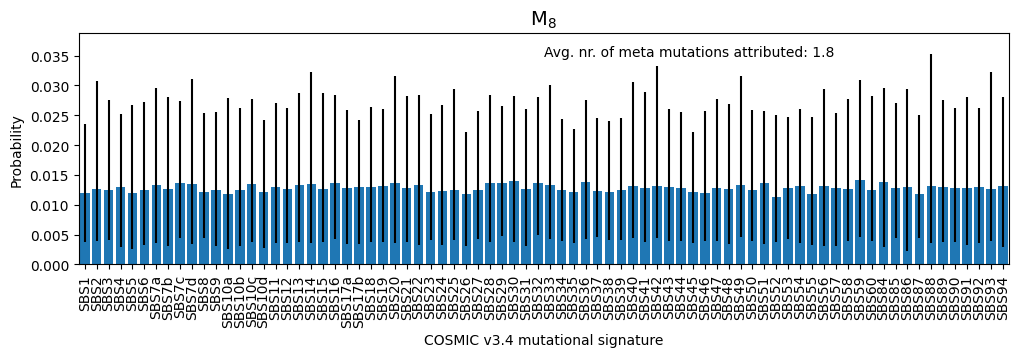

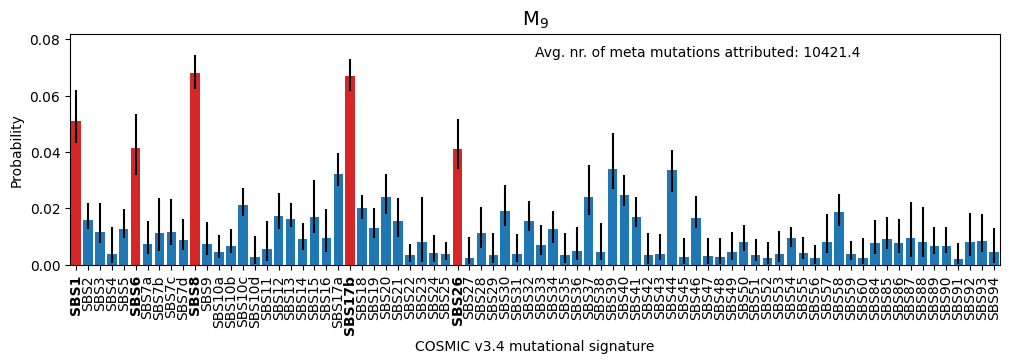

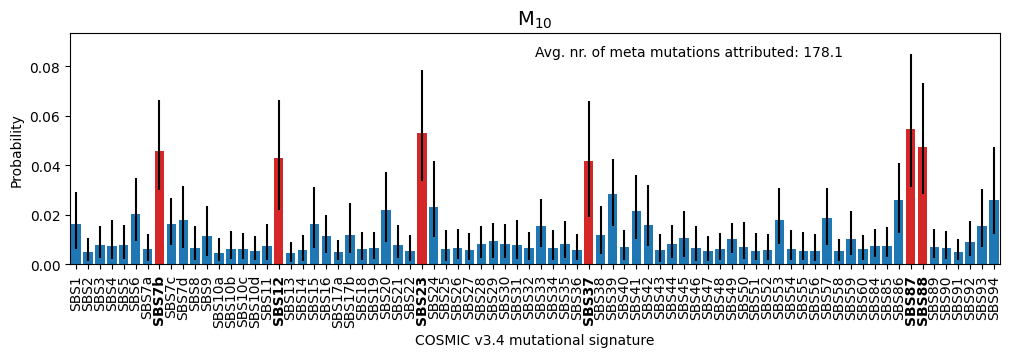

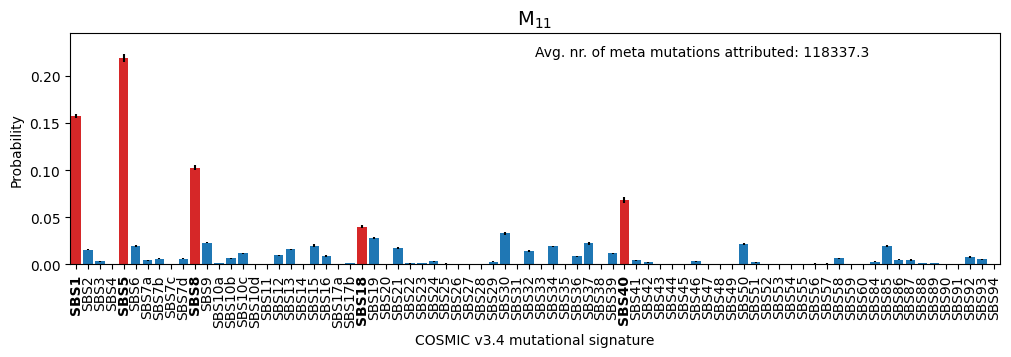

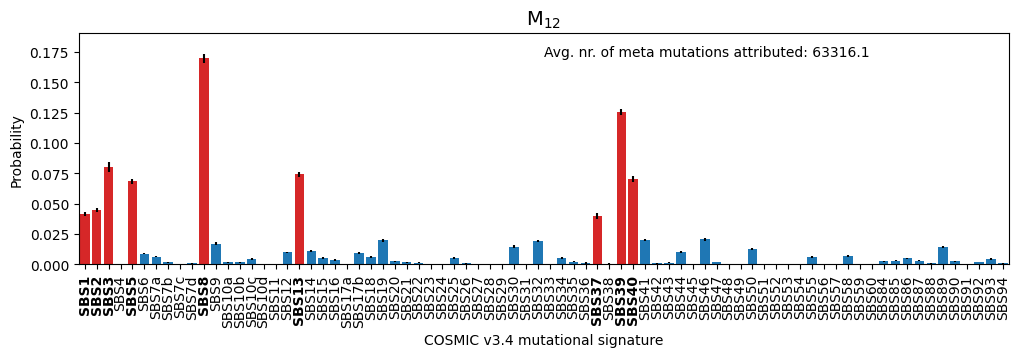

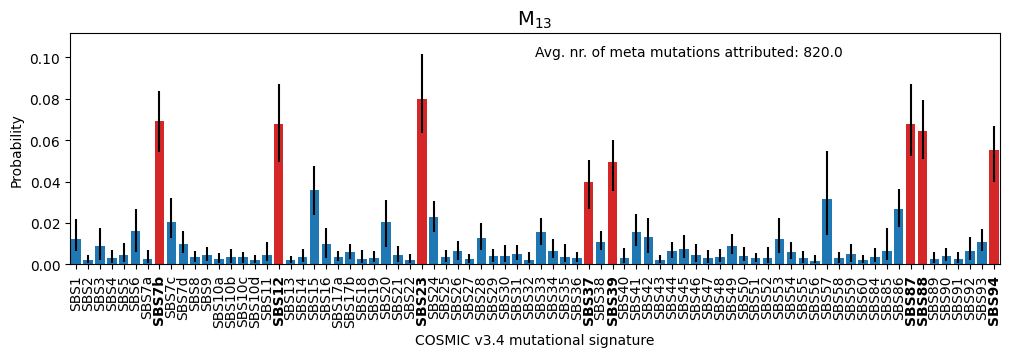

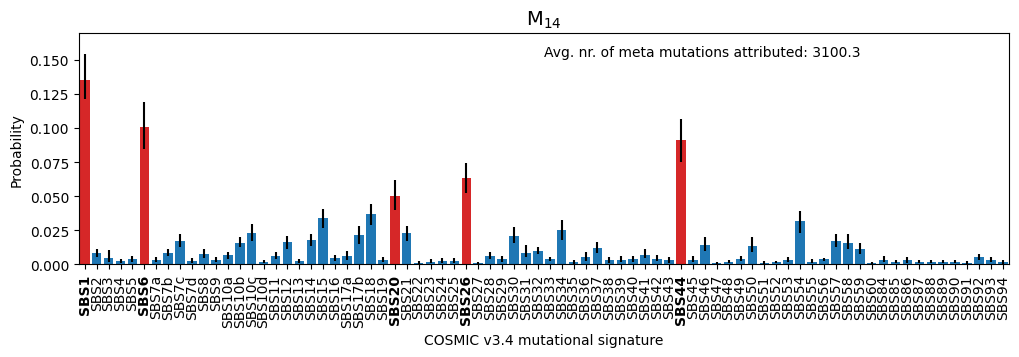

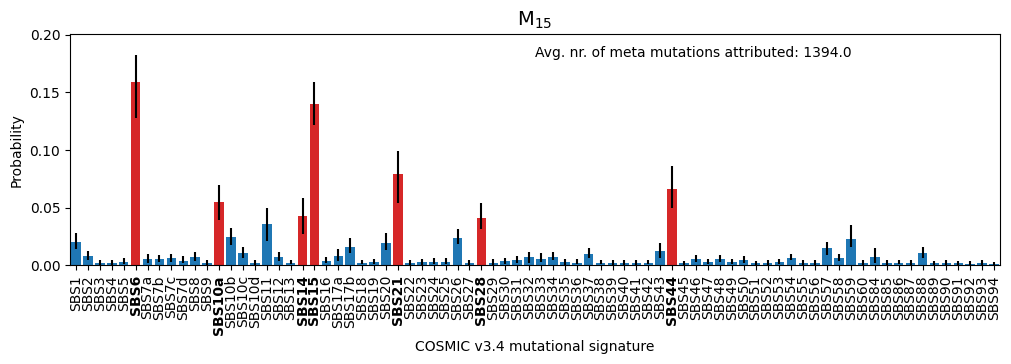

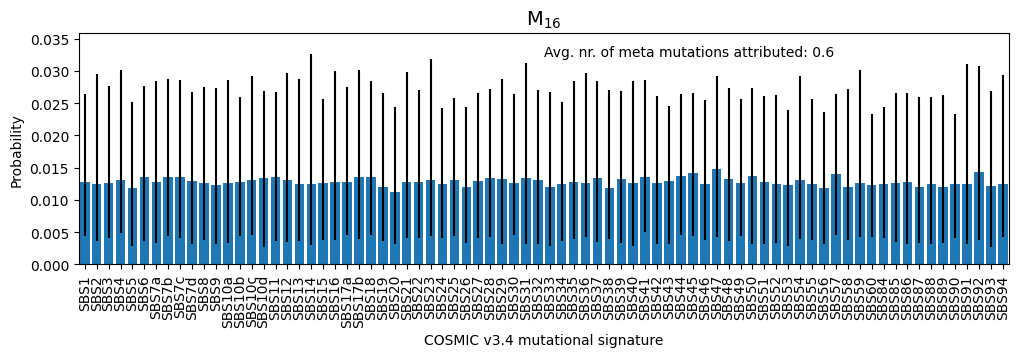

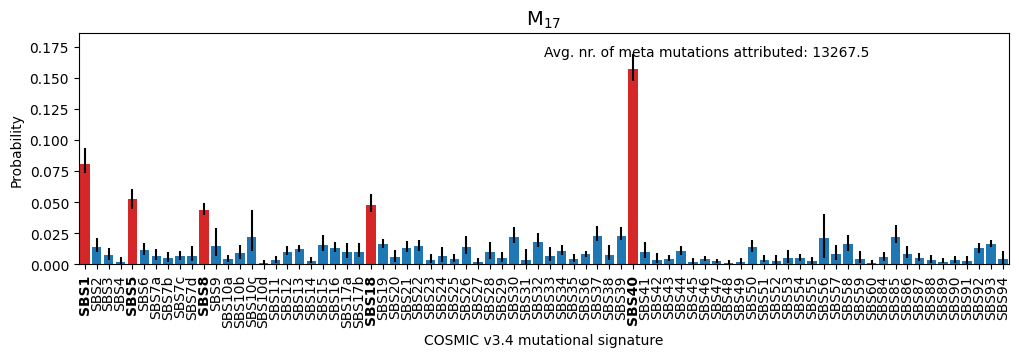

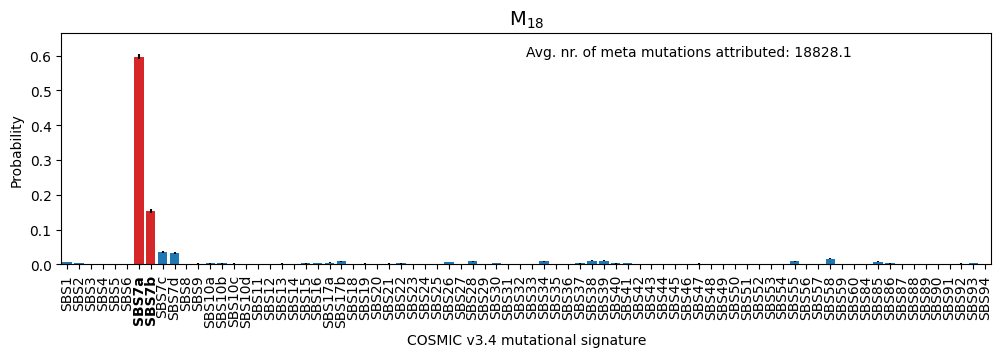

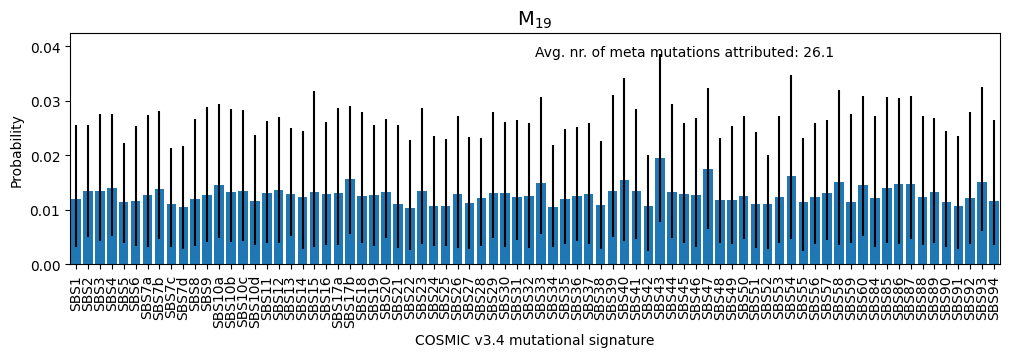

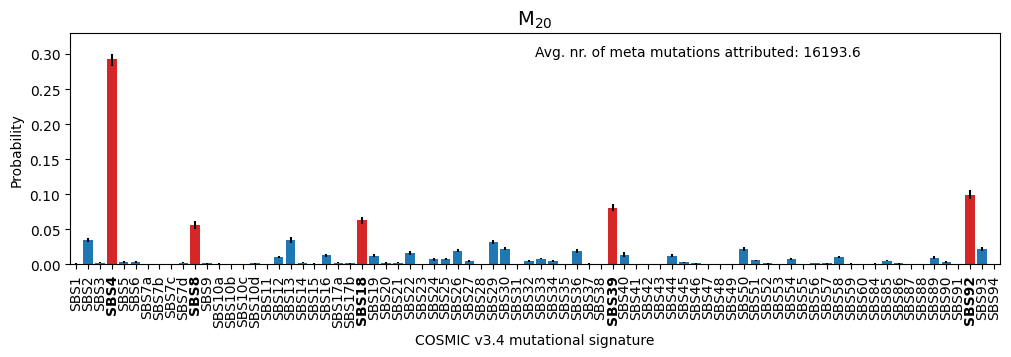

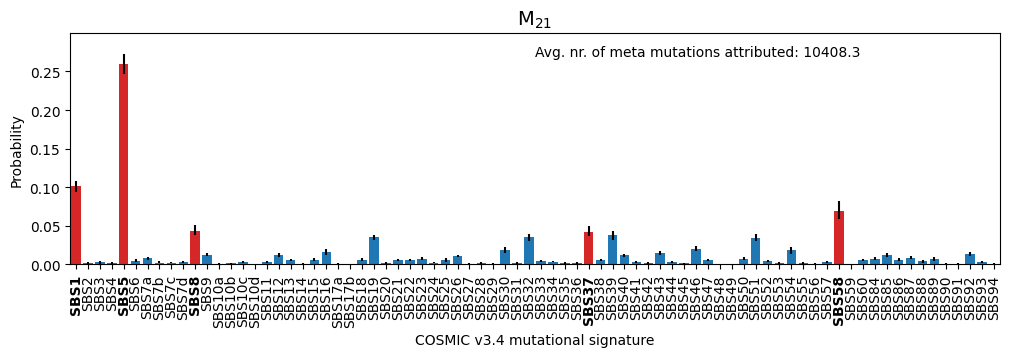

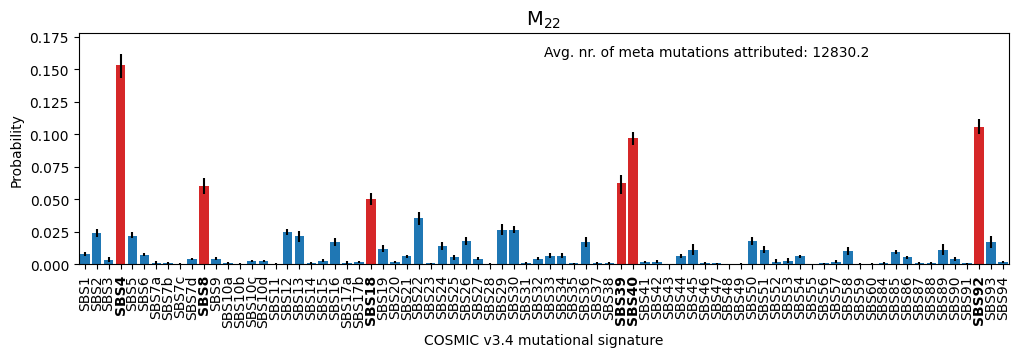

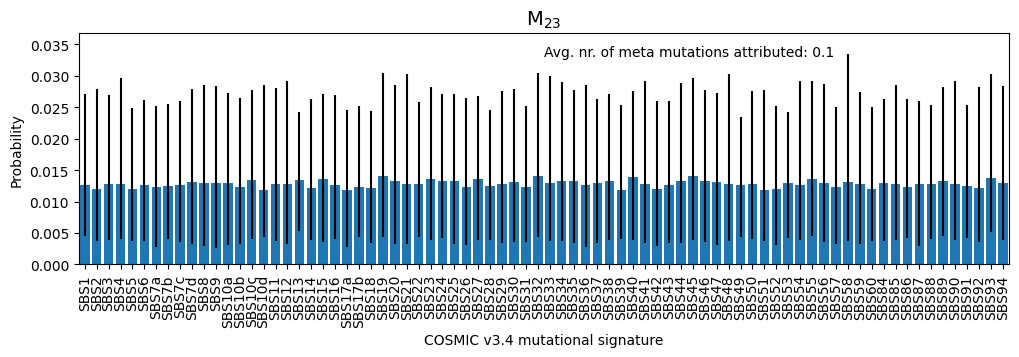

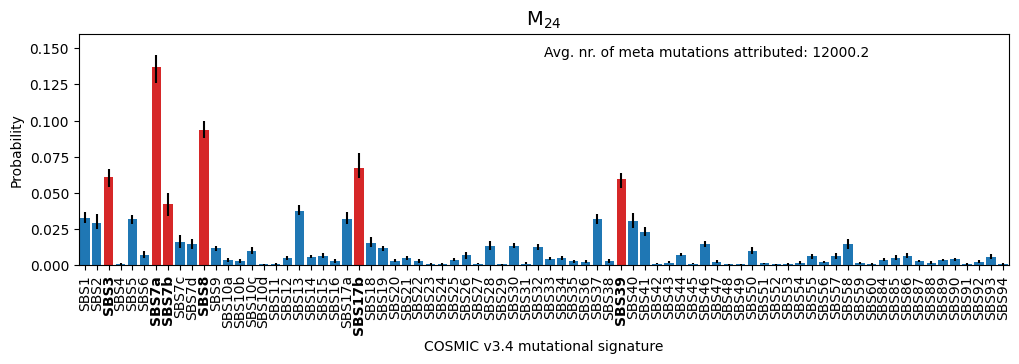

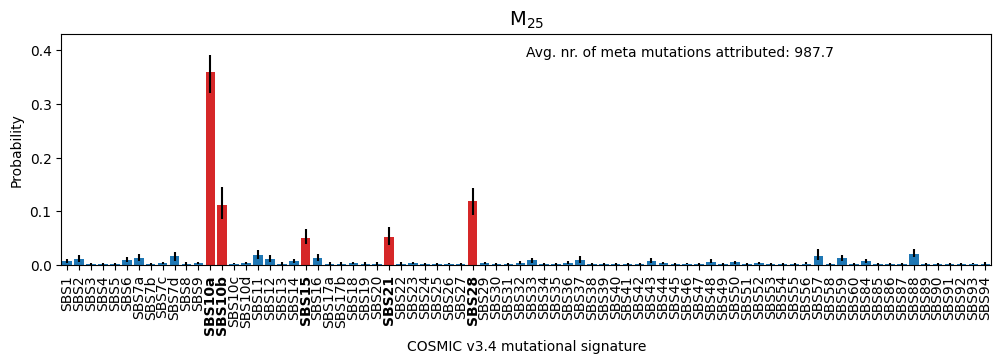

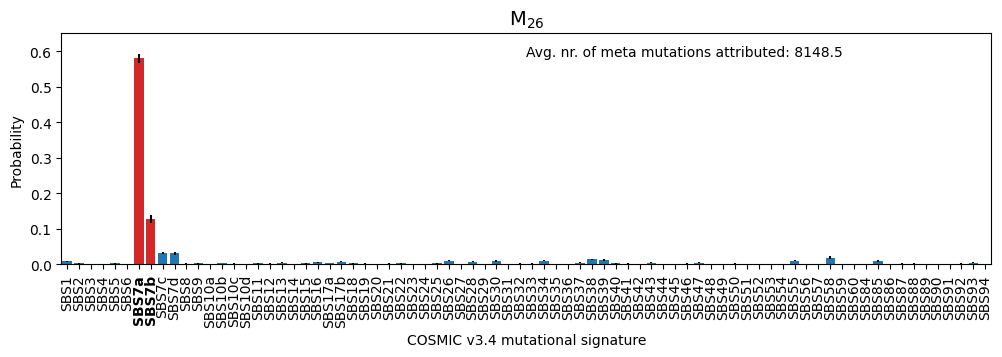

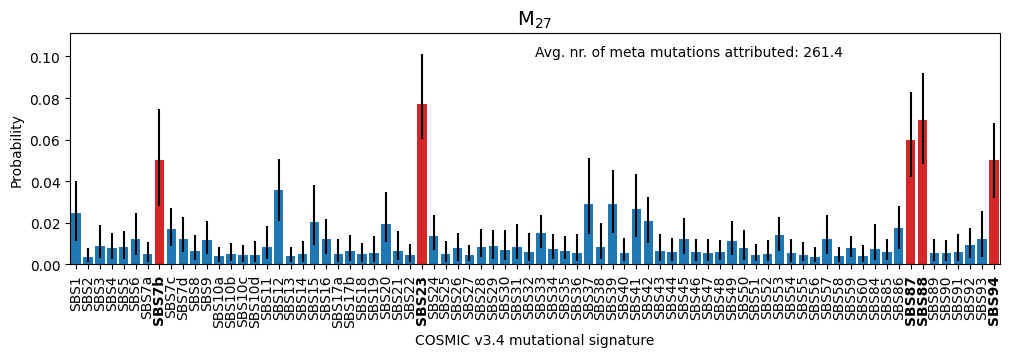

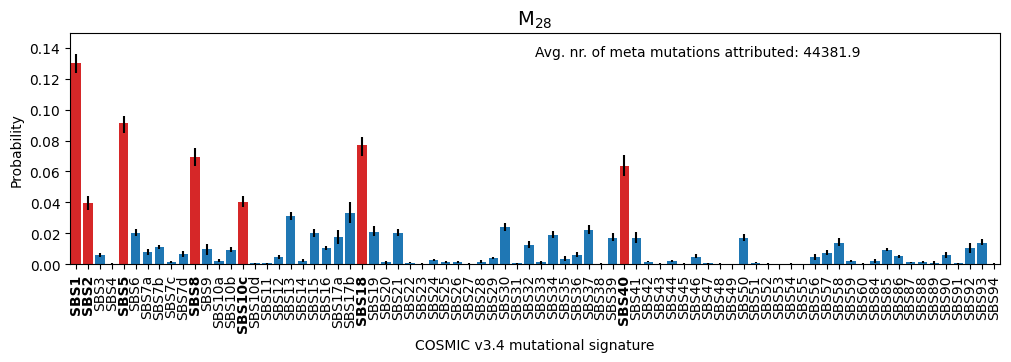

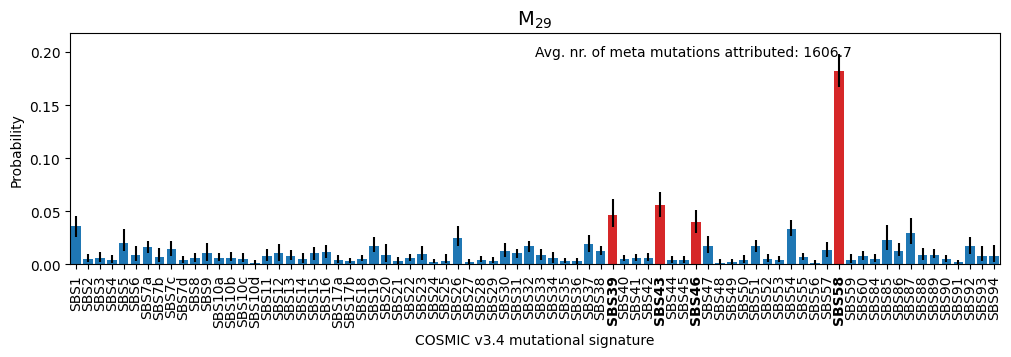

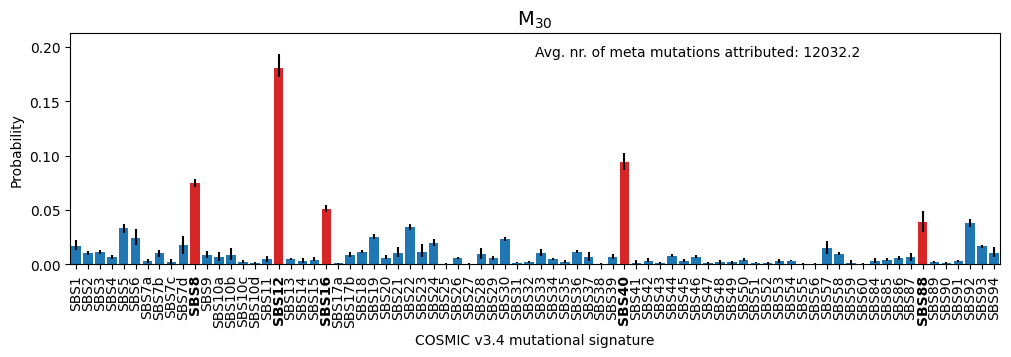

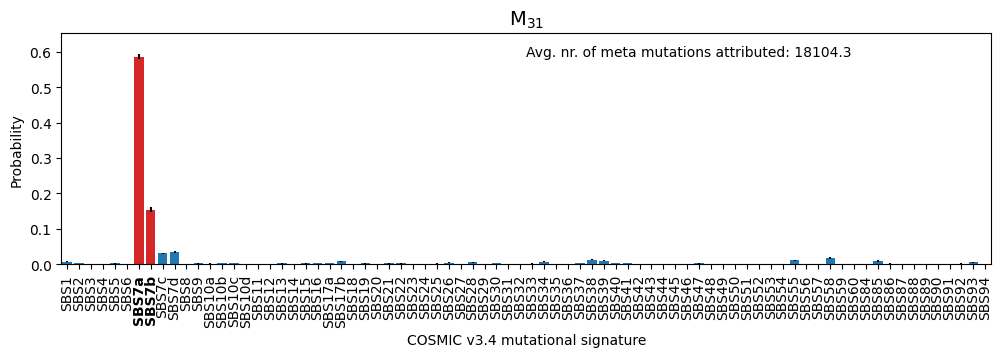

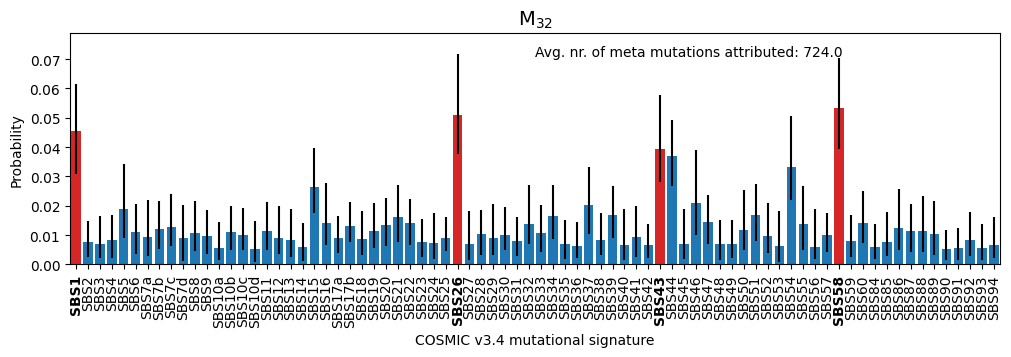

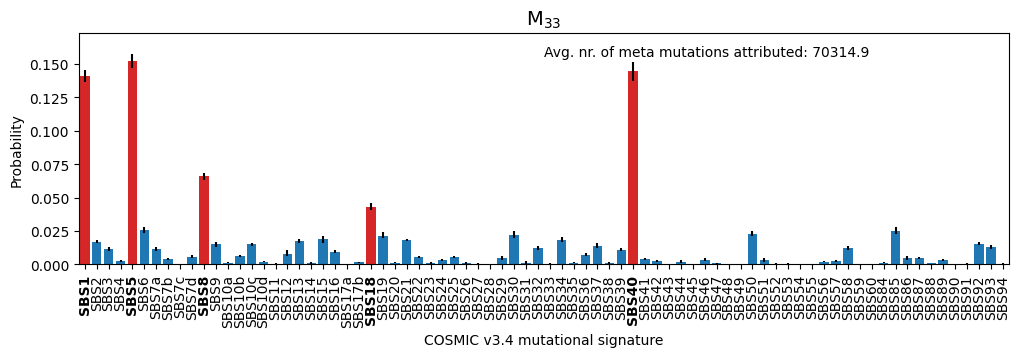

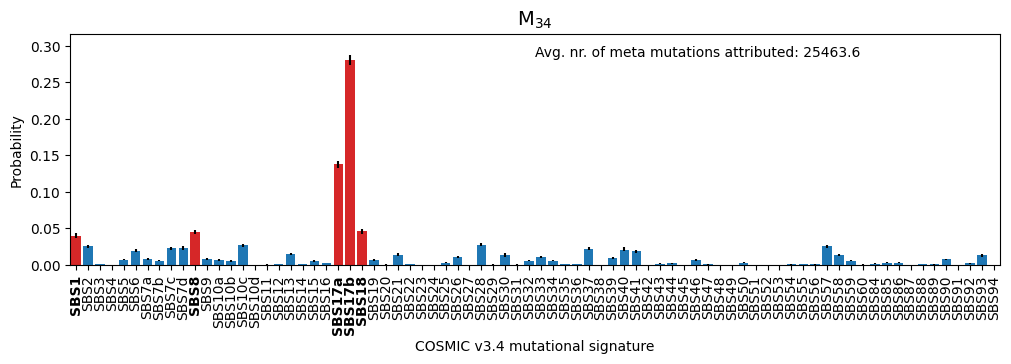

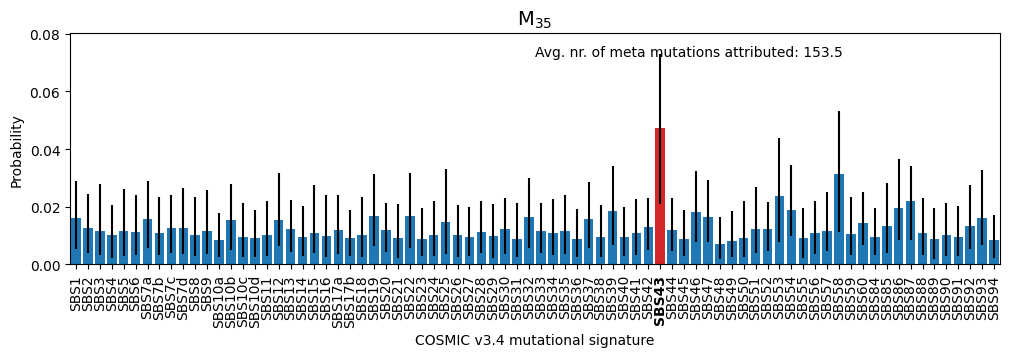

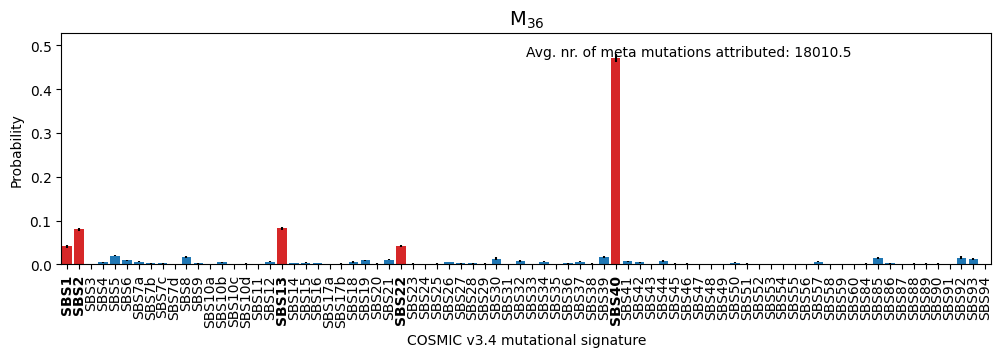

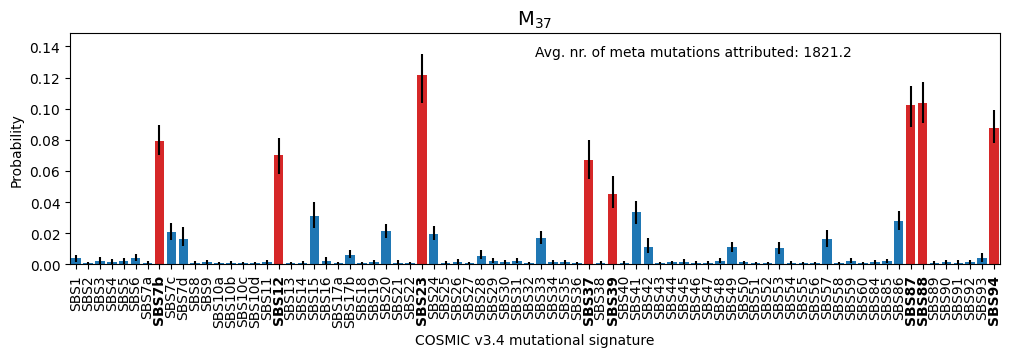

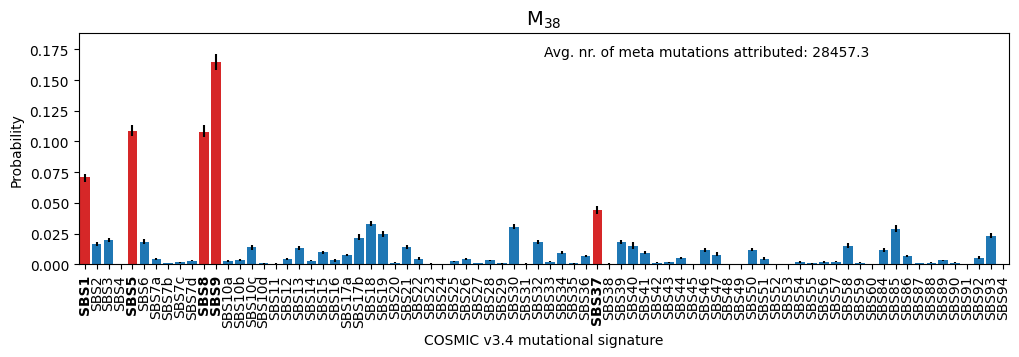

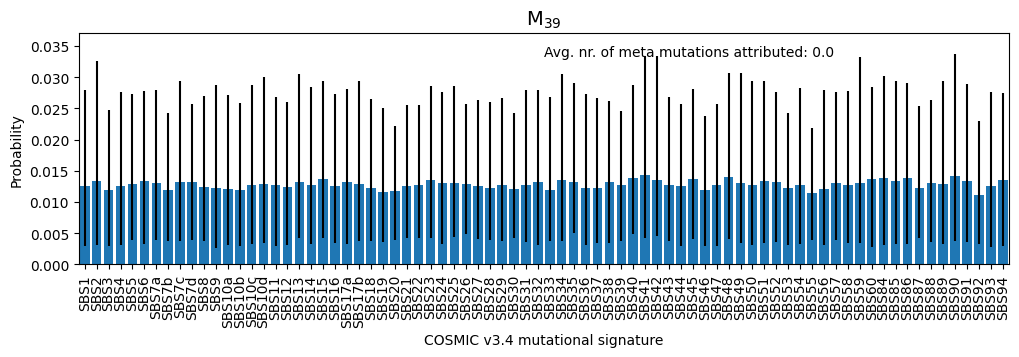

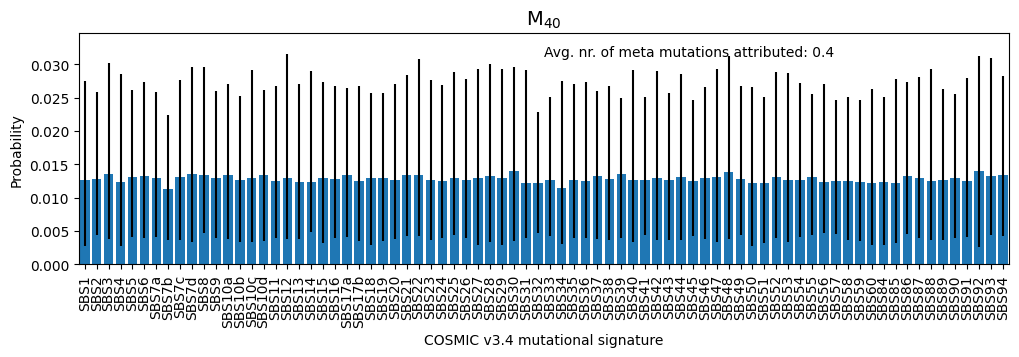

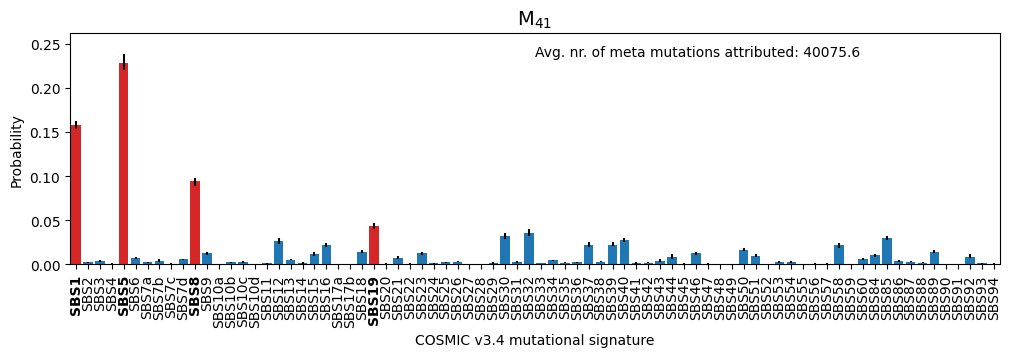

In [18]:
for name, idx in remaining_names.items():
    f = plt.figure(figsize=(12, 3))
    plt.title(f"Mutational signatures that typically go together in a sample for\nMeta Signature: {name}\n", fontsize=14)
    plot_cosmic_2nd_order_signatures_95ci(centroid_trace[:, idx])
    output_name = name.replace('$', '').replace('_', '').replace('{', '').replace('}', '')
    # Compute the number of meta mutations that were attributed to these meta-signatures.
    avg_meta_counts = m_k[np.arange(4), cluster_assignments_inv[:, idx]].mean()
    plt.text(0.5, 0.9, f'Avg. nr. of meta mutations attributed: {avg_meta_counts:.1f}', transform=plt.gca().transAxes, ha="center")
    f.savefig(f'../figures/meta_signatures/{output_name}_meta.png', bbox_inches='tight', dpi=300)

C:\Users\John\AppData\Local\Temp\ipykernel_9552\4059563730.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(12, 3))


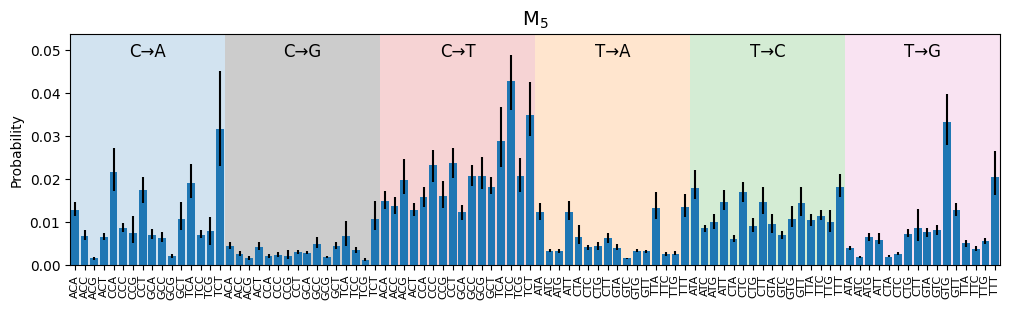

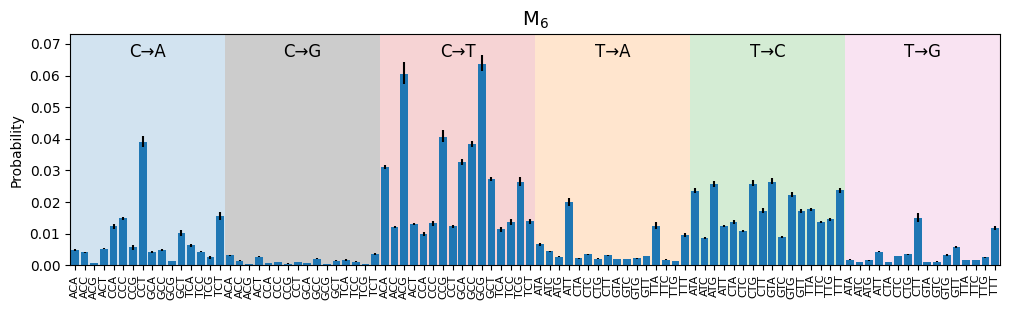

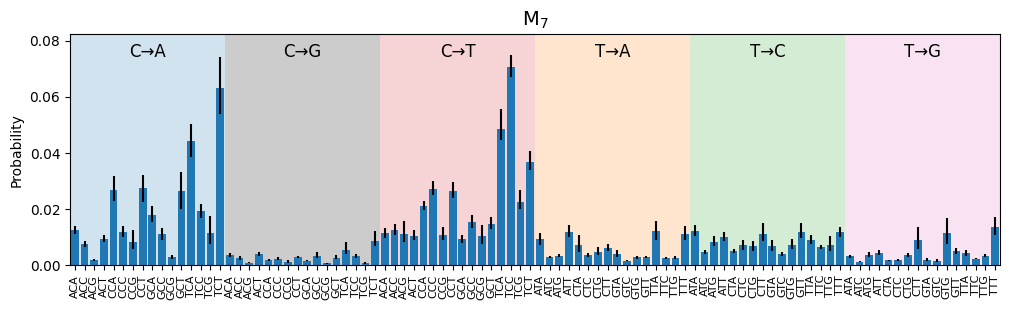

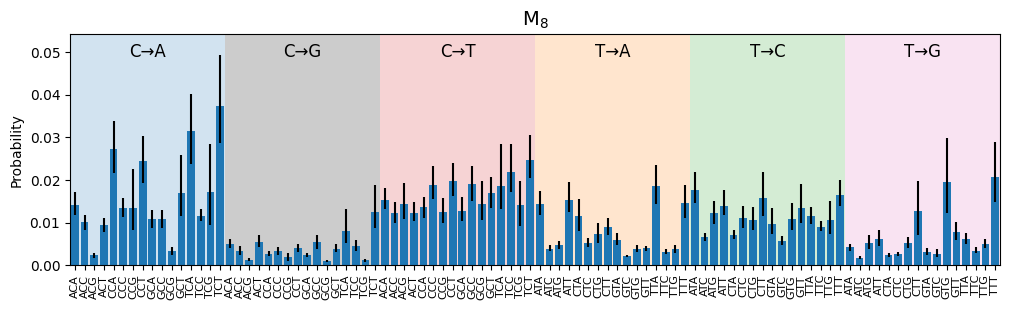

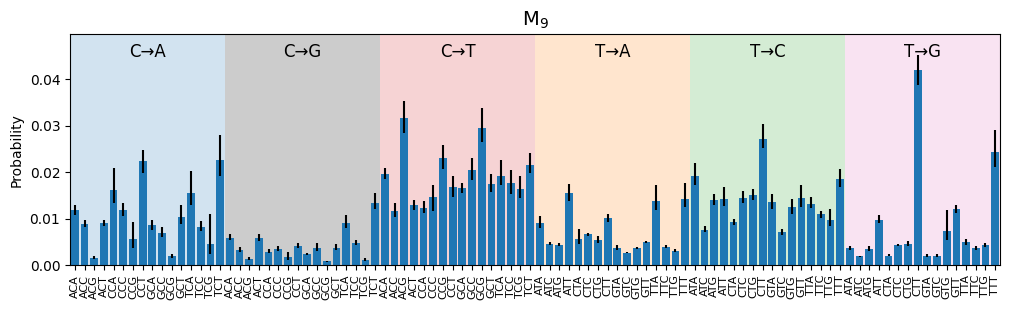

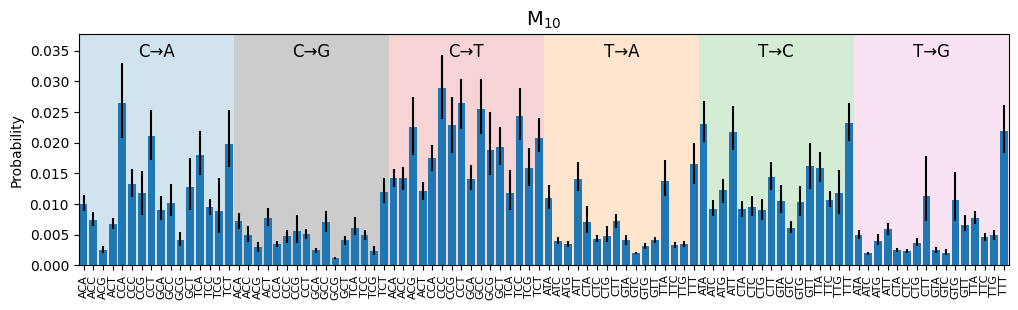

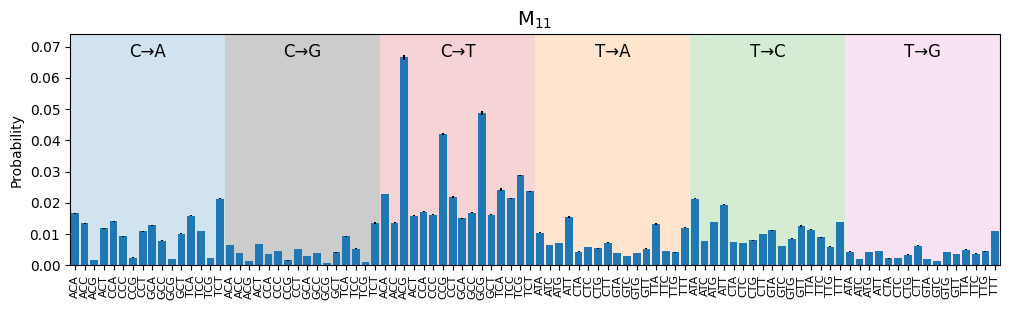

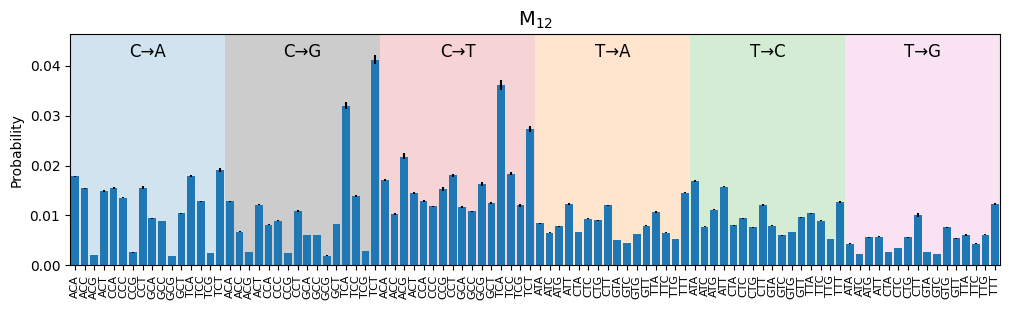

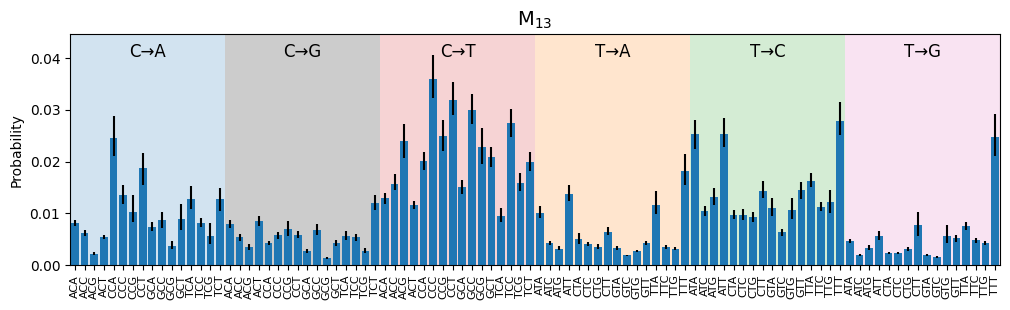

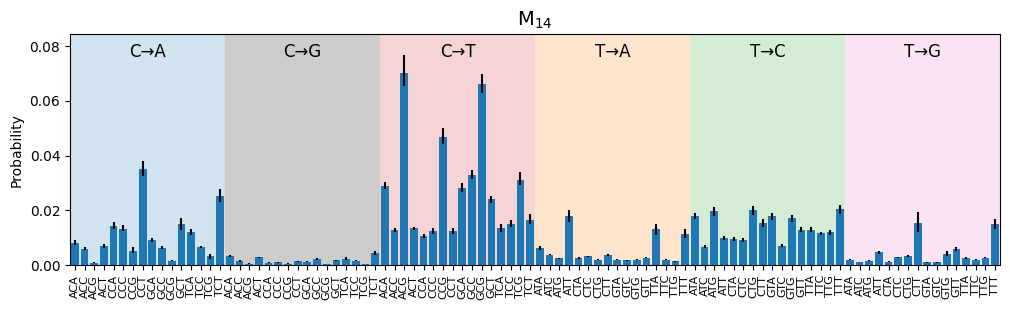

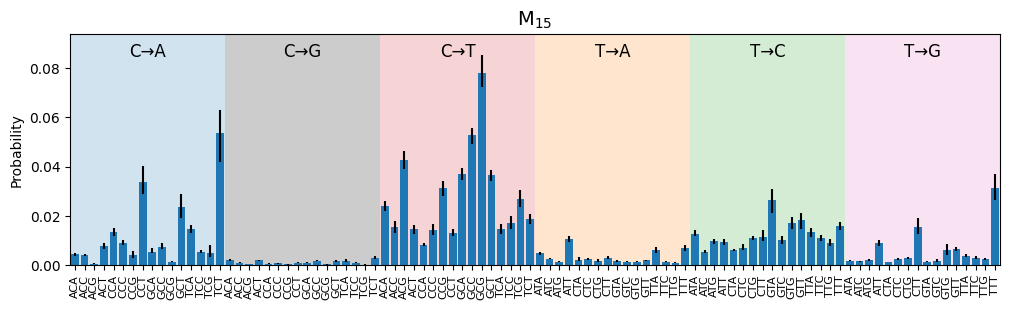

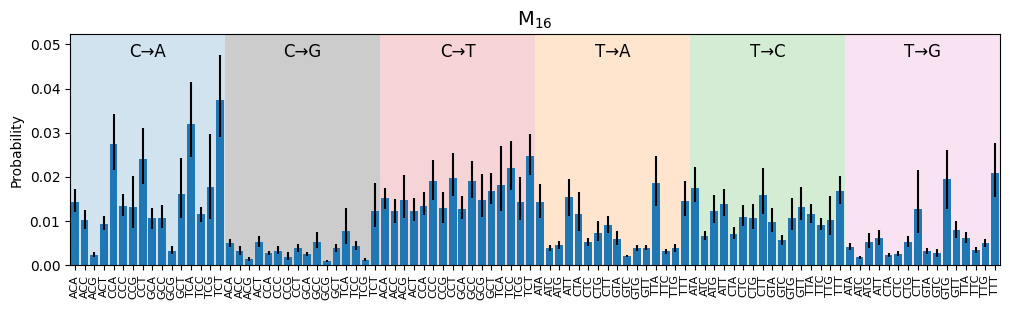

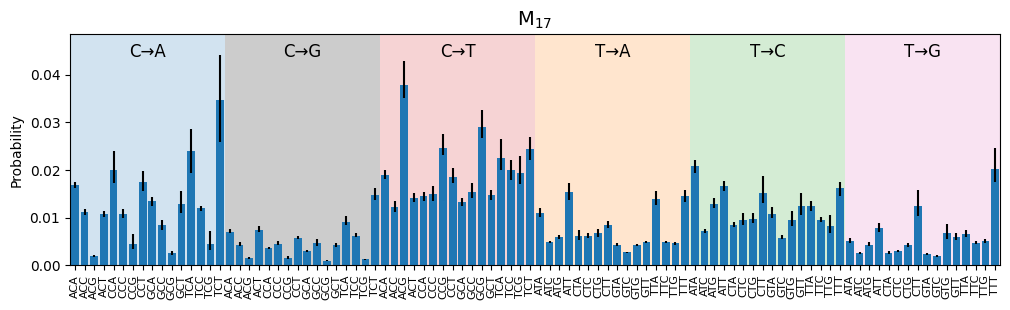

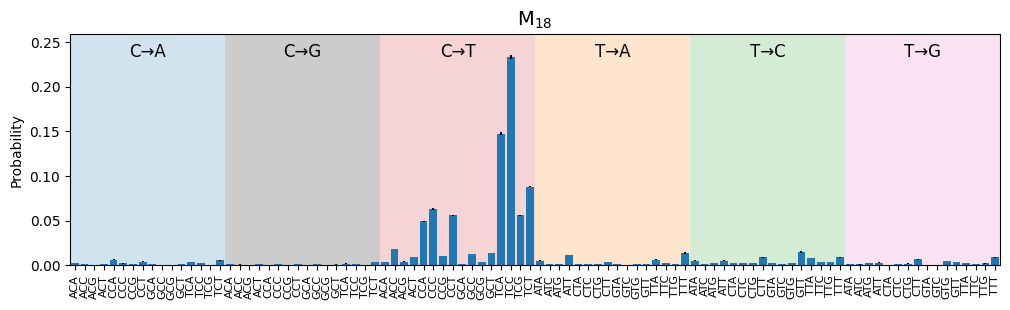

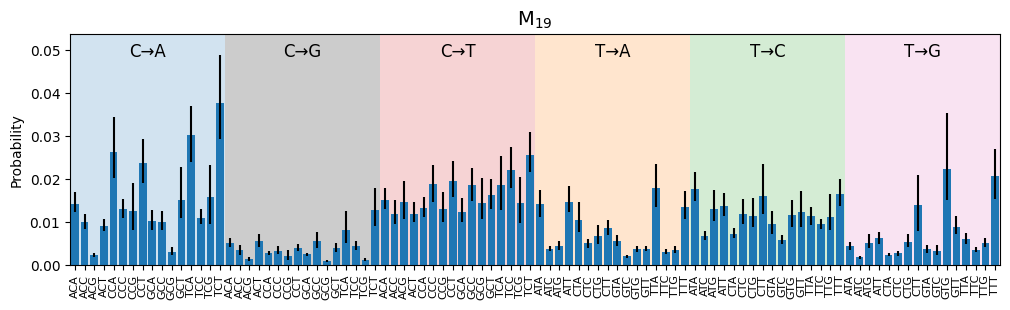

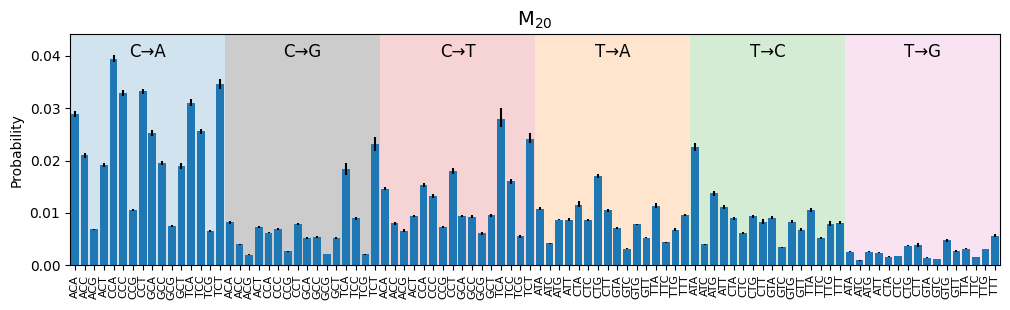

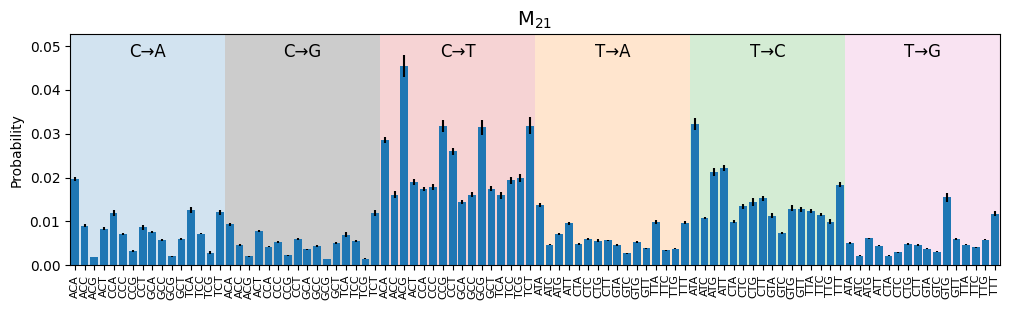

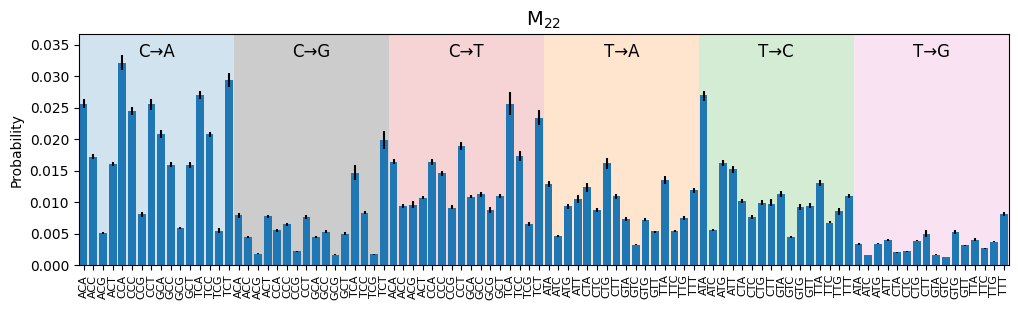

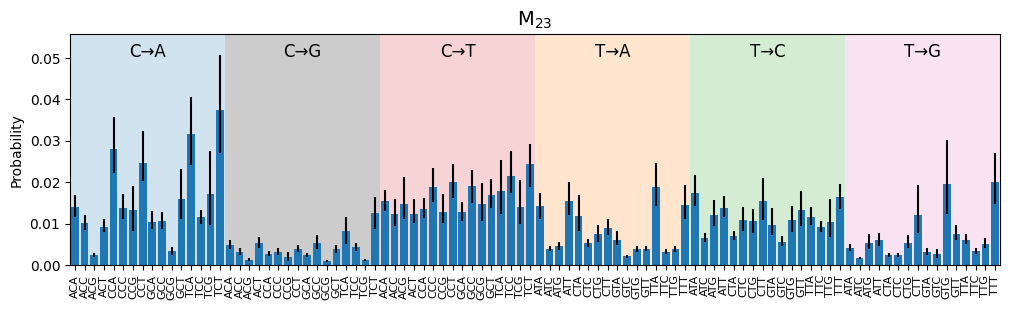

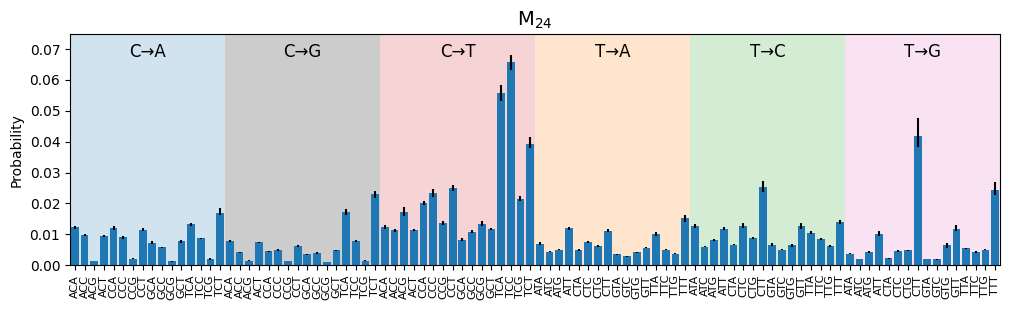

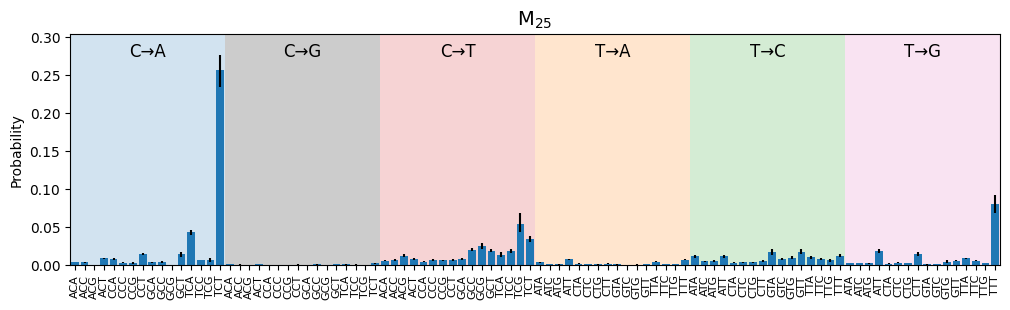

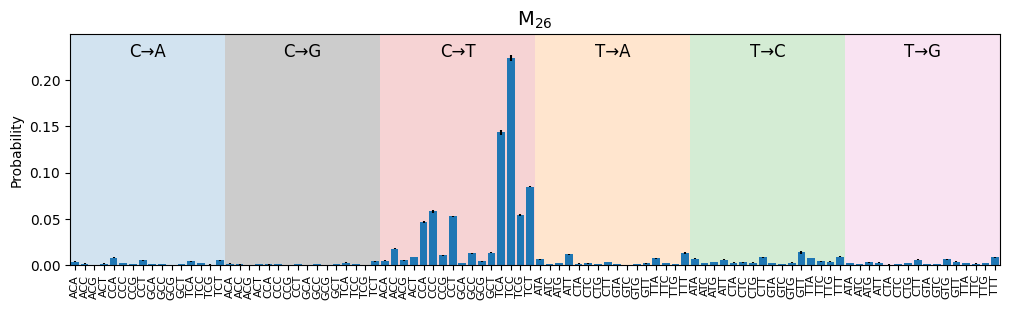

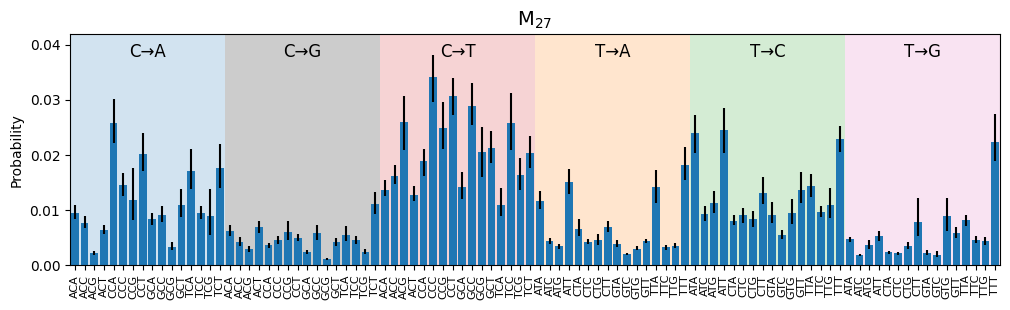

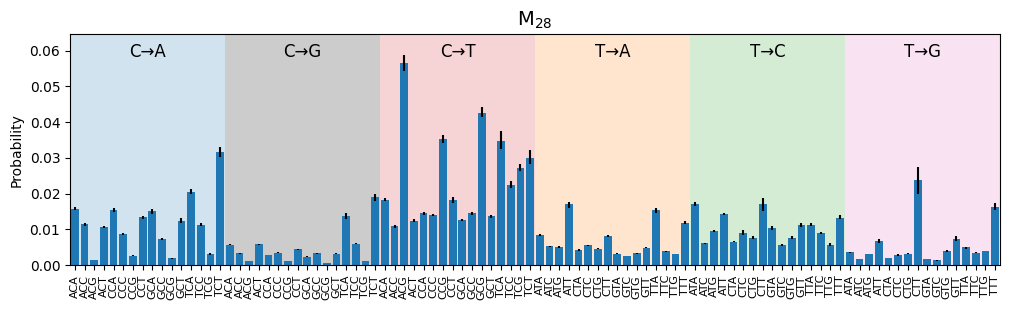

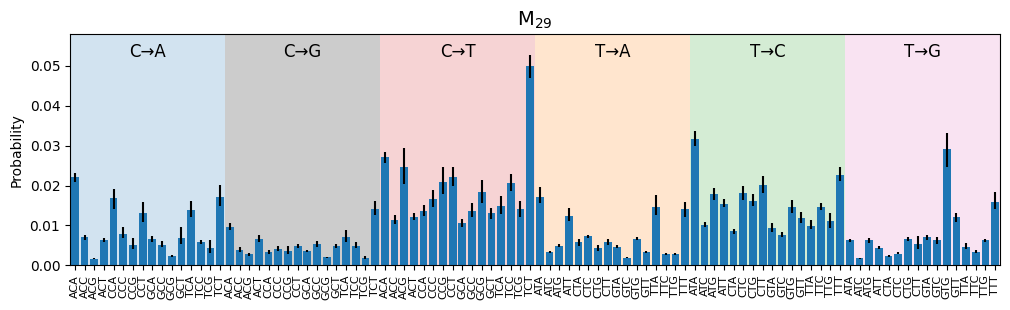

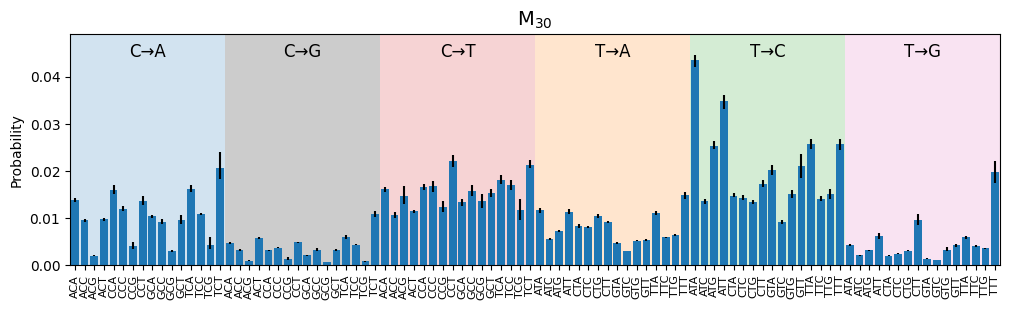

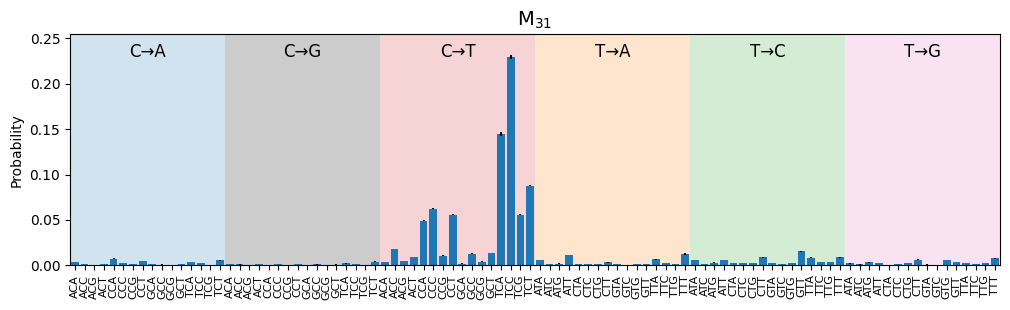

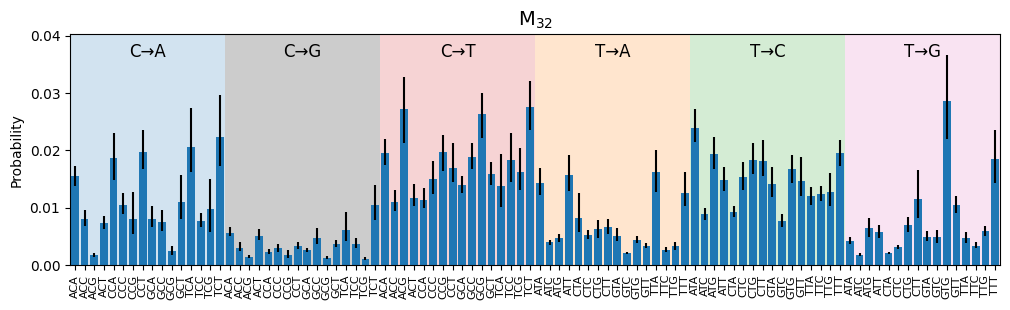

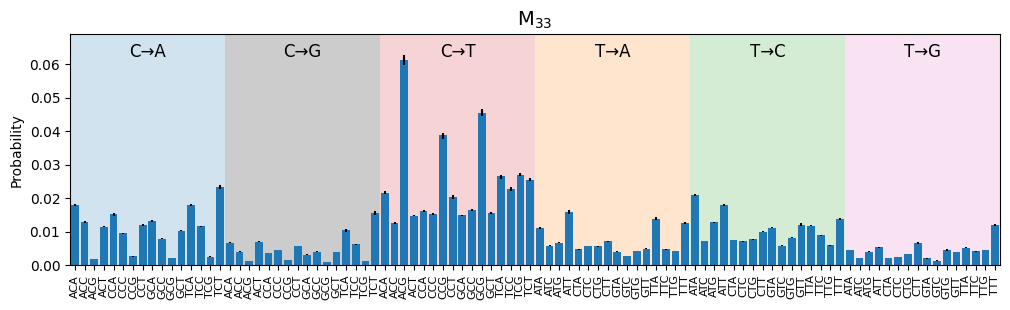

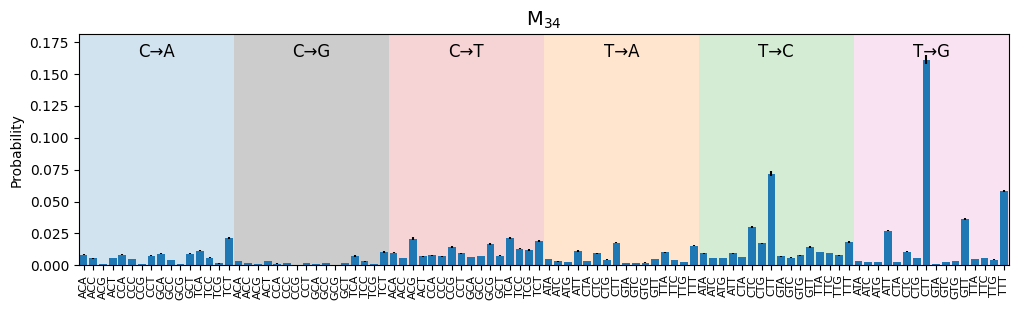

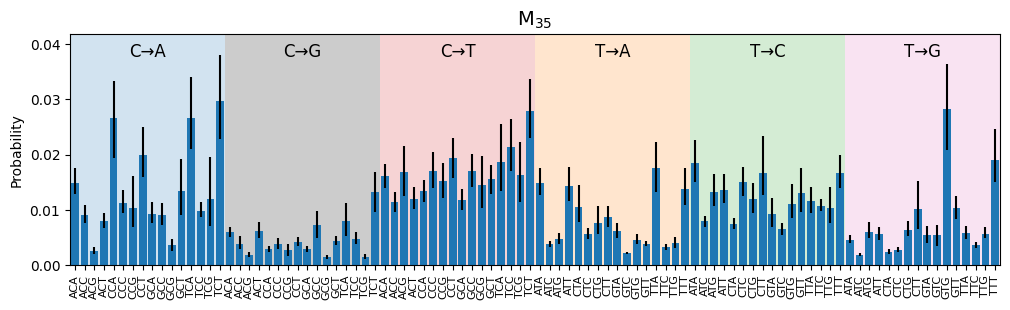

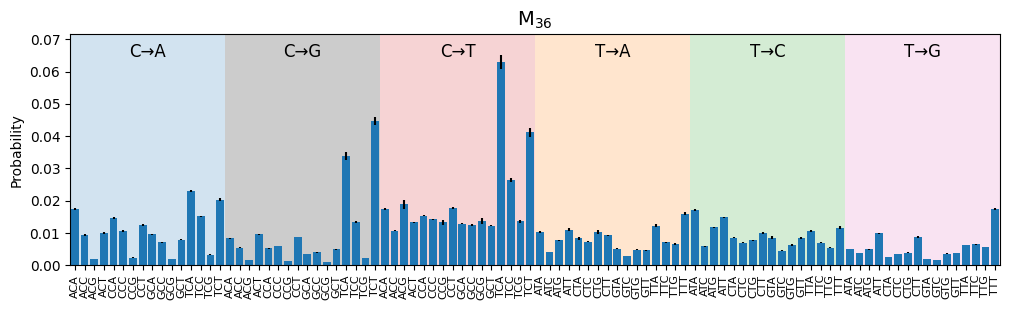

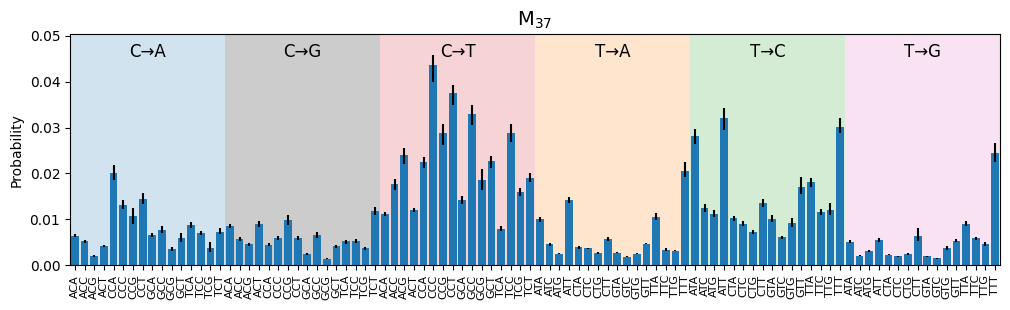

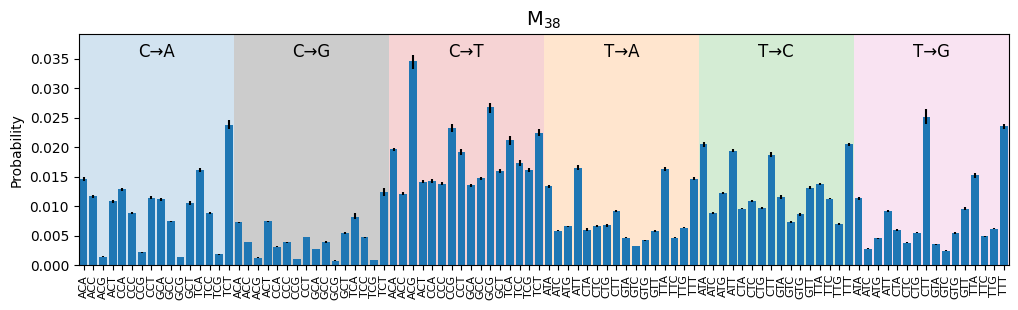

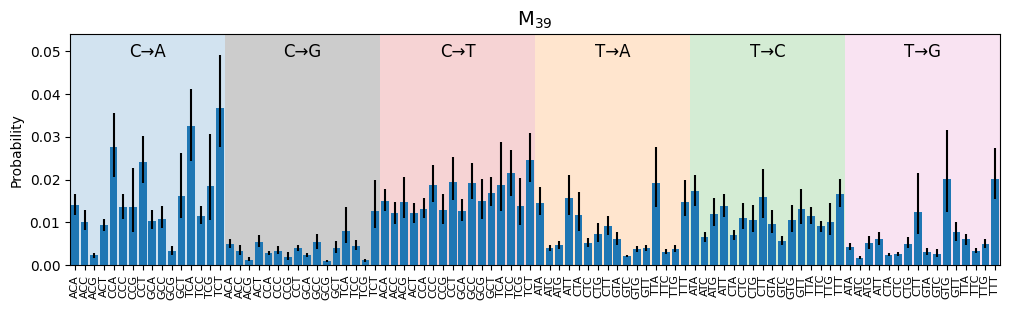

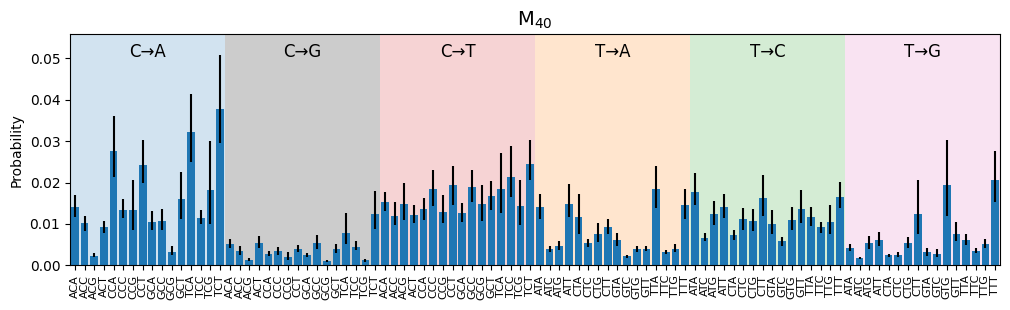

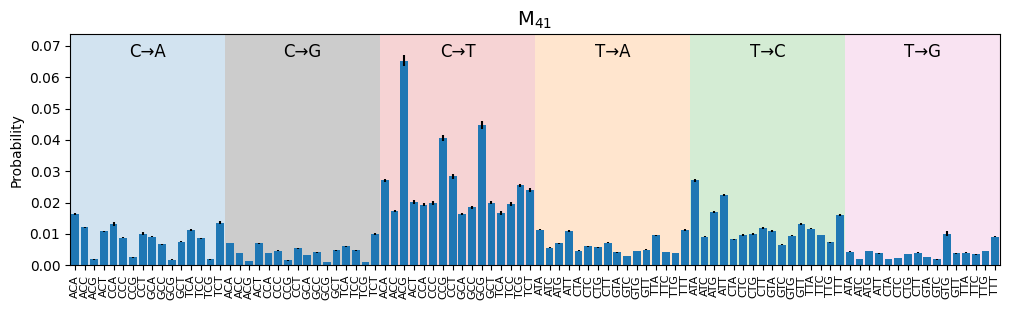

In [19]:
for name, idx in remaining_names.items():
    f = plt.figure(figsize=(12, 3))
    plt.title(f"Trinucleotide probability for\nMeta Signature {name}", fontsize=14)
    spectrum_plot_with_95ci(phi_phi_trace[:, idx])
    output_name = name.replace('$', '').replace('_', '').replace('{', '').replace('}', '')
    f.savefig(f'../figures/meta_signatures/{output_name}_spectrum.png', bbox_inches='tight', dpi=300)